## Data import and Cleaning

In [61]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

epitopes = pd.read_csv(r'/Users/tariq/Documents/capstone/data/epitope_full_seq.csv')
assays = pd.read_csv(r'/Users/tariq/Documents/capstone/data/tcell_table_export_1740279970.csv')

# make all the column names snake case
epitopes.columns = epitopes.columns.str.lower()
assays.columns = assays.columns.str.lower()

# remove spaces from column names
epitopes.columns = epitopes.columns.str.replace(' ', '')
epitopes.columns = epitopes.columns.str.replace('-', ' ')
epitopes.columns = epitopes.columns.str.replace(' ', '_')

assays.columns = assays.columns.str.replace(' ', '')
assays.columns = assays.columns.str.replace('-', ' ')
assays.columns = assays.columns.str.replace(' ', '_')

epitopes = epitopes.filter(['epitope_objecttype', 'epitope_name', 'fullsequence'])
assays = assays.filter(['epitope_name', 'epitope_moluculeparent', 'host_name', 'host_mhcpresent', 'assay_method','assay_responsemeasured', 'assay_qualitativemeasurement', 'mhcrestriction_name', 'mhcrestriction_class', 'assayantigen_name'])

# map mhc name and class from the assays dataframe to a new column in the epitopes dataframe based on epitope_name
mhc = assays.filter(['epitope_name', 'mhcrestriction_name', 'mhcrestriction_class'])
mhc = mhc.drop_duplicates(subset=['epitope_name'])
epitopes = epitopes.merge(mhc, on='epitope_name', how='left')

/var/folders/5j/4p7c5_1x2fg18bk0nf74_hg40000gn/T/ipykernel_71348/1747643720.py:8: DtypeWarning: Columns (13,14,45,46,47,48,49,54,55,56,57,60,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,105,106,107,108,109,110,111,112,113,115,120,123,128,132,134,135,141,142,143,144,145,149,152) have mixed types. Specify dtype option on import or set low_memory=False.
  assays = pd.read_csv(r'/Users/tariq/Documents/capstone/data/tcell_table_export_1740279970.csv')


In [62]:
epitopes.head()

,epitope_objecttype,epitope_name,fullsequence,mhcrestriction_name,mhcrestriction_class
0,Linear peptide,AAGIGILTV,MPREDAHFIYGYPKKGHGHSYTTAEEAAGIGILTVILGVLLLIGCW...,HLA-A2,I
1,Linear peptide,AAGIGILTVI,MPREDAHFIYGYPKKGHGHSYTTAEEAAGIGILTVILGVLLLIGCW...,HLA-A*02:01,I
2,Linear peptide,ACDPHSGHFV,NaN,HLA-A2,I
3,Linear peptide,ADLVGFLLLK,MSLEQRSLHCKPEEALEAQQEALGLVCVQAATSSSSPLVLGTLEEV...,HLA-A*11:01,I
4,Linear peptide,ADVEFCLSL,MLLAVLYCLLWSFQTSAGHFPRACVSSKNLMEKECCPPWSGDRSPC...,HLA-B*44:03,I


In [63]:
epitopes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28681 entries, 0 to 28680
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   epitope_objecttype    28681 non-null  object
 1   epitope_name          28681 non-null  object
 2   fullsequence          7164 non-null   object
 3   mhcrestriction_name   17613 non-null  object
 4   mhcrestriction_class  17613 non-null  object
dtypes: object(5)
memory usage: 1.1+ MB


## Feature Engineering

In [64]:
epitopes['epitope_length'] = epitopes['epitope_name'].str.len()

In [65]:
# Function to count amino acids in a peptide
def count_amino_acids(peptide):
    try:
        # Create a ProteinAnalysis object for the peptide
        analyzer = ProteinAnalysis(peptide)
        # Get amino acid counts and normalize to frequencies
        aa_count = analyzer.count_amino_acids()
        total_aa = sum(aa_count.values())
        aa_freq = {aa: count for aa, count in aa_count.items()}
        # Add the peptide itself to the results
        aa_freq['peptide'] = peptide
        return aa_freq
    except Exception as e:
        # Handle invalid peptides (e.g., with non-standard amino acids)
        result = {aa: 0 for aa in 'ACDEFGHIKLMNPQRSTVWY'}
        result['peptide'] = peptide
        return result

# Create analyzer function that will be used in the next cell
def analyzer(peptide):
    return count_amino_acids(peptide)

# Use both epitope name and peptide sequence in the DataFrame
epitope_composition_df = epitopes.apply(lambda row: count_amino_acids(row['epitope_name']), axis=1).apply(pd.Series)


In [66]:
epitope_composition_df.head()

,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,peptide
0,2,0,0,0,0,2,0,2,0,1,...,0,0,0,0,0,1,1,0,0,AAGIGILTV
1,2,0,0,0,0,2,0,3,0,1,...,0,0,0,0,0,1,1,0,0,AAGIGILTVI
2,1,1,1,0,1,1,2,0,0,0,...,0,1,0,0,1,0,1,0,0,ACDPHSGHFV
3,1,0,1,0,1,1,0,0,1,4,...,0,0,0,0,0,0,1,0,0,ADLVGFLLLK
4,1,1,1,1,1,0,0,0,0,2,...,0,0,0,0,1,0,1,0,0,ADVEFCLSL


In [67]:
# Example DataFrame with a 'peptide' column
df = pd.DataFrame({
    'peptide': ['ACDEFGHIK', 'LMNPQRSTV', 'WYFP']
})

# Kyte-Doolittle hydrophobicity scale
kyte_doolittle = {
    'I': 4.5, 'V': 4.2, 'L': 3.8, 'F': 2.8, 'C': 2.5,
    'M': 1.9, 'A': 1.8, 'G': -0.4, 'T': -0.7, 'S': -0.8,
    'W': -0.9, 'Y': -1.3, 'P': -1.6, 'H': -3.2, 'E': -3.5,
    'Q': -3.5, 'D': -3.5, 'N': -3.5, 'K': -3.9, 'R': -4.5
}

def compute_avg_hydrophobicity(peptide):
    # Get hydrophobicity scores for each amino acid; default to 0 if missing
    scores = [kyte_doolittle.get(aa, 0) for aa in peptide]
    return sum(scores) / len(scores) if scores else 0

# Apply the function to the 'peptide' column to create a new column 'avg_hydro'
epitopes['epitope_avg_hydro'] = epitopes['epitope_name'].apply(compute_avg_hydrophobicity)

In [68]:
# Import the molecular_weight function from Bio.SeqUtils
from Bio.SeqUtils.ProtParam import ProteinAnalysis

def calculate_molecular_weight(peptide):
    """Calculate the molecular weight of a peptide sequence using Biopython."""
    try:
        # ProteinAnalysis only works with standard amino acids
        protein = ProteinAnalysis(peptide)
        return protein.molecular_weight()
    except Exception as e:
        # Handle peptides with non-standard amino acids
        return None

# Apply the function to calculate molecular weight for each epitope
epitopes['molecular_weight'] = epitopes['epitope_name'].apply(calculate_molecular_weight)

In [69]:
def calculate_aromaticity(peptide):
    """Calculate the aromaticity of a peptide sequence using Biopython."""
    try:
        # ProteinAnalysis only works with standard amino acids
        protein = ProteinAnalysis(peptide)
        return protein.aromaticity()
    except Exception as e:
        # Handle peptides with non-standard amino acids
        return None

# Apply the function to calculate molecular weight for each epitope
epitopes['aromaticity'] = epitopes['epitope_name'].apply(calculate_aromaticity)

In [70]:
def calculate_isoelectric_point(peptide):
    """Calculate the isoelectric point of a peptide sequence using Biopython."""
    try:
        # ProteinAnalysis only works with standard amino acids
        protein = ProteinAnalysis(peptide)
        return protein.isoelectric_point()
    except Exception as e:
        # Handle peptides with non-standard amino acids
        return None

# Apply the function to calculate molecular weight for each epitope
epitopes['isoelectric_point'] = epitopes['epitope_name'].apply(calculate_isoelectric_point)

In [71]:
def calculate_instability(peptide):
    """Calculate the instability of a peptide sequence using Biopython."""
    try:
        # ProteinAnalysis only works with standard amino acids
        protein = ProteinAnalysis(peptide)
        return protein.instability_index()
    except Exception as e:
        # Handle peptides with non-standard amino acids
        return None

# Apply the function to calculate molecular weight for each epitope
epitopes['instability'] = epitopes['epitope_name'].apply(calculate_instability)

In [72]:
epitopes.head()

,epitope_objecttype,epitope_name,fullsequence,mhcrestriction_name,mhcrestriction_class,epitope_length,epitope_avg_hydro,molecular_weight,aromaticity,isoelectric_point,instability
0,Linear peptide,AAGIGILTV,MPREDAHFIYGYPKKGHGHSYTTAEEAAGIGILTVILGVLLLIGCW...,HLA-A2,I,9,2.122222,813.9814,0.000000,5.570017,11.422222
1,Linear peptide,AAGIGILTVI,MPREDAHFIYGYPKKGHGHSYTTAEEAAGIGILTVILGVLLLIGCW...,HLA-A*02:01,I,10,2.360000,927.1390,0.000000,5.570017,11.280000
2,Linear peptide,ACDPHSGHFV,NaN,HLA-A2,I,10,-0.140000,1069.1507,0.100000,5.972266,61.830000
3,Linear peptide,ADLVGFLLLK,MSLEQRSLHCKPEEALEAQQEALGLVCVQAATSSSSPLVLGTLEEV...,HLA-A*11:01,I,10,1.620000,1088.3394,0.100000,5.880358,-16.470000
4,Linear peptide,ADVEFCLSL,MLLAVLYCLLWSFQTSAGHFPRACVSSKNLMEKECCPPWSGDRSPC...,HLA-B*44:03,I,9,1.233333,996.1348,0.111111,4.050028,20.855556


## Generation of Negative Samples

In [14]:
def generate_negatives(row):
    epitope = row["epitope_name"]
    full_seq = row["fullsequence"]
    mhc = row["mhcrestriction_name"]
    
    # Handle missing or empty sequences
    if pd.isnull(full_seq) or full_seq == "":
        return []
    
    epitope = str(epitope)
    full_seq = str(full_seq)
    ep_len = len(epitope)
    
    negatives = []
    for i in range(len(full_seq) - ep_len + 1):
        window = full_seq[i:i+ep_len]
        if window != epitope:
            negatives.append({"peptide": window, "mhc": mhc})
    return negatives

# Apply the function to each row

#negatives = pd.DataFrame()
#negatives['negatives'] = epitopes.apply(generate_negatives, axis=1)
#negatives = negatives[["negatives"]].explode("negatives").reset_index(drop=True)
#negatives.dropna(subset=["negatives"], inplace=True)


# Remove duplicate peptide-mhc combinations
#print(f"Shape before removing duplicates: {negatives.shape}")
#negatives = negatives.drop_duplicates(subset=['negatives'])
#print(f"Shape after removing duplicates: {negatives.shape}")

# Check for any remaining NaN values
#print(f"Number of NaN values in negatives: {negatives['negatives'].isna().sum()}")


# Extract peptide and mhc into separate columns
#negatives['peptide'] = negatives['negatives'].apply(lambda x: x['peptide'])
#negatives['mhc'] = negatives['negatives'].apply(lambda x: x['mhc'])

# Calculate features on the peptide column
#negatives['peptide_length'] = negatives['peptide'].apply(len)
#negatives['peptide_avg_hydro'] = negatives['peptide'].apply(compute_avg_hydrophobicity)


# Drop the original dictionary column if no longer needed
#negatives.drop('negatives', axis=1, inplace=True)

In [15]:
negatives_composition_df = pd.read_csv("data/negatives_composition_df.csv")
negatives = pd.read_csv("data/negatives_MHC.csv")

negatives['molecular_weight'] = negatives['peptide'].apply(calculate_molecular_weight)
negatives['aromaticity'] = negatives['peptide'].apply(calculate_aromaticity)
negatives['isoelectric_point'] = negatives['peptide'].apply(calculate_isoelectric_point)
negatives_composition_df = negatives['peptide'].apply(count_amino_acids).apply(pd.Series)

negatives.to_csv("data/negatives_MHC.csv", index=False)

In [20]:
nine_mers = epitopes[epitopes['epitope_length'] == 9]
nine_mers.to_csv("data/nine_mer_epitopes.csv", index=False)

In [22]:
ninemer_negatives = negatives[negatives['peptide_length'] == 9]
ninemer_negatives_trimmed = ninemer_negatives[:50000]
ninemer_negatives_trimmed.to_csv("data/ninemer_negatives_trimmed.csv", index=False)

## EDA

### Data Summary

In [ ]:
epitopes.head()

In [ ]:
epitope_composition_df.head()

In [ ]:
epitopes.info()

In [ ]:
epitope_composition_df.info()

### Properties of Epitopes

#### Length

In [ ]:
# hist of epitope length
plt.figure(figsize=(10, 6))
plt.hist(epitopes['epitope_length'], bins=20, edgecolor='black')
plt.xlabel('Epitope Length')
plt.ylabel('Frequency')
plt.title('Histogram of Epitope Length')
plt.show()

In [ ]:
epitopes['epitope_length'].describe()

#### Hydrophobicity

In [ ]:
# histogram of average hydrophobicity
plt.figure(figsize=(10, 6))
plt.hist(epitopes['epitope_avg_hydro'], bins=20, edgecolor='black')
plt.xlabel('Average Hydrophobicity')
plt.ylabel('Frequency')
plt.title('Histogram of Average Epitope Hydrophobicity')
plt.show()

In [ ]:
epitopes['epitope_avg_hydro'].describe()

#### Composition

In [ ]:
# plot the composition of the epitopes, sort by the composition of the amino acids
# Calculate mean composition and sort
mean_composition = epitope_composition_df.mean().sort_values(ascending=False)

# Plot the sorted composition
plt.figure(figsize=(10, 6))
plt.bar(mean_composition.index, mean_composition.values)
plt.xlabel('Amino Acid')
plt.ylabel('Composition')
plt.title('Composition of Epitopes')
plt.show()

#### n-gram frequency analysis

In [ ]:
def ngram_frequency(peptides, n=2):
    ngrams = []
    for peptide in peptides:
        if len(peptide) < n:
            continue
        for i in range(len(peptide) - n + 1):
            ngram = peptide[i:i+n]
            ngrams.append(ngram)
    return Counter(ngrams)

dipeptide_freq = ngram_frequency(epitopes['epitope_name'], n=2)

df_ngram = pd.DataFrame(dipeptide_freq.items(), columns=['ngram', 'count'])
df_ngram = df_ngram.sort_values('count', ascending=False)

top_n = 20
top_ngram = df_ngram.head(top_n)

plt.figure(figsize=(12, 6))
sns.barplot(x='ngram', y='count', data=top_ngram, palette="viridis")
plt.title(f"Epitopes Top {top_n} Dipeptides Frequency")
plt.xlabel("Dipeptide")
plt.ylabel("Frequency")
plt.show()

#### MHC Binding Affinity

In [ ]:
negatives_MHC = pd.read_csv("data/negatives_MHC.csv")
MHC_predictions = pd.read_csv("data/MHC_predictions_20250311_010323.csv")

negatives_MHC_trimmed = negatives_MHC[:5000]
# Save the trimmed negatives_MHC dataframe to a CSV file
negatives_MHC_trimmed.to_csv("data/negatives_MHC_trimmed.csv", index=False)

### Properties of negative samples

In [ ]:
# hist of negative length
plt.figure(figsize=(10, 6))
plt.hist(negatives['peptide_length'], bins=20, edgecolor='black')
plt.xlabel('Negative Length')
plt.ylabel('Frequency')
plt.title('Histogram of Negative Length')
plt.show()

In [ ]:
# histogram of average hydrophobicity
plt.figure(figsize=(10, 6))
plt.hist(negatives['peptide_avg_hydro'], bins=20, edgecolor='black')
plt.xlabel('Average Hydrophobicity')
plt.ylabel('Frequency')
plt.title('Histogram of Negative Average Hydrophobicity')
plt.show()

In [ ]:
negatives['peptide_avg_hydro'].mean()

In [ ]:
# plot the composition of the negatives, sort by the composition of the amino acids
# Calculate mean composition and sort
mean_composition = negatives_composition_df.mean().sort_values(ascending=False)

# Plot the sorted composition
plt.figure(figsize=(10, 6))
plt.bar(mean_composition.index, mean_composition.values)
plt.xlabel('Amino Acid')
plt.ylabel('Composition')
plt.title('Composition of Negative Samples')
plt.show()

## Modeling

### Data Preprocessing

In [57]:
epitopes = pd.read_csv("data/ninemer_epitopes.csv")
epitopes = epitopes.drop(columns=['epitope_objecttype', 'fullsequence', 'mhcrestriction_name', 'mhcrestriction_class', 'epitope_length'])
epitopes = epitopes.rename(columns={'epitope_name': 'peptide', 'epitope_avg_hydro': 'peptide_avg_hydro'})
epitopes_BA_pred = pd.read_csv("data/ninemer_epitopes_BA_pred.csv")
epitopes_composition = epitopes.apply(lambda row: count_amino_acids(row['peptide']), axis=1).apply(pd.Series)

negatives = pd.read_csv("data/ninemer_negatives_trimmed.csv")
negatives = negatives.drop(columns=['mhc', 'peptide_length'])
negatives = negatives.rename(columns={'peptide': 'peptide'})
negatives = negatives.drop_duplicates(subset=['peptide'])
negatives_BA_pred = pd.read_csv("data/ninemer_negatives_trimmed_BA_pred.csv")
negatives_BA_pred = negatives_BA_pred.drop_duplicates(subset=['peptide'])
negatives_composition = negatives.apply(lambda row: count_amino_acids(row['peptide']), axis=1).apply(pd.Series)

In [58]:
# Merge the 'Score_BA' column from epitopes_BA_pred into the epitopes dataframe
epitopes = pd.merge(epitopes, epitopes_BA_pred[['peptide', 'Score_BA']], on='peptide', how='left')
epitopes = pd.merge(epitopes, epitopes_composition, on='peptide', how='left')

negatives = pd.merge(negatives, negatives_BA_pred[['peptide', 'Score_BA']], on='peptide', how='left')
negatives = pd.merge(negatives, negatives_composition, on='peptide', how='left')

In [59]:
def calculate_instability(peptide):
    """Calculate the instability of a peptide sequence using Biopython."""
    try:
        # ProteinAnalysis only works with standard amino acids
        protein = ProteinAnalysis(peptide)
        return protein.instability_index()
    except Exception as e:
        # Handle peptides with non-standard amino acids
        return None

# Apply the function to calculate molecular weight for each epitope
epitopes['instability'] = epitopes['peptide'].apply(calculate_instability)

In [60]:
epitopes.head()

,peptide,peptide_avg_hydro,molecular_weight,aromaticity,isoelectric_point,Score_BA,A,C,D,E,...,N,P,Q,R,S,T,V,W,Y,instability
0,AAGIGILTV,2.122222,813.9814,0.000000,5.570017,NaN,2,0,0,0,...,0,0,0,0,0,1,1,0,0,11.422222
1,ADVEFCLSL,1.233333,996.1348,0.111111,4.050028,0.190368,1,1,1,1,...,0,0,0,0,1,0,1,0,0,20.855556
2,AFLPWHRLF,0.533333,1186.4061,0.333333,9.800371,0.677877,1,0,0,0,...,0,1,0,1,0,0,0,1,0,53.400000
3,ALAETSYVK,0.155556,981.1004,0.111111,6.045191,0.652230,2,0,0,1,...,0,0,0,0,1,1,1,0,1,5.688889
4,ALDVYNGLL,0.966667,977.1115,0.111111,4.050028,0.493034,1,0,1,0,...,1,0,0,0,0,0,1,0,1,-16.188889


In [50]:
negatives.head()

,peptide,peptide_avg_hydro,molecular_weight,aromaticity,isoelectric_point,Score_BA,A,C,D,E,...,M,N,P,Q,R,S,T,V,W,Y
0,MPREDAHFI,-0.588889,1115.2622,0.111111,5.302703,0.304493,1,0,1,1,...,1,0,1,0,1,0,0,0,0,0
1,PREDAHFIY,-0.944444,1147.2394,0.222222,5.328337,0.015808,1,0,1,1,...,0,0,1,0,1,0,0,0,0,1
2,REDAHFIYG,-0.811111,1107.1755,0.222222,5.320607,0.054031,1,0,1,1,...,0,0,0,0,1,0,0,0,0,1
3,EDAHFIYGY,-0.455556,1114.1630,0.333333,4.353321,0.027312,1,0,1,1,...,0,0,0,0,0,0,0,0,0,2
4,DAHFIYGYP,-0.244444,1082.1642,0.333333,5.076654,0.056538,1,0,1,0,...,0,0,1,0,0,0,0,0,0,2


In [52]:
# Add label column to epitopes dataframe (positive class = 1)
epitopes['label'] = 1

# Add label column to negatives dataframe (negative class = 0)
negatives['label'] = 0

# Combine the positive and negative examples
combined_data = pd.concat([epitopes, negatives], ignore_index=True)

# Shuffle the combined dataset
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Define features and target
X = combined_data.drop(columns=['peptide', 'label'])
y = combined_data['label']

# Identify numerical columns to scale (exclude one-hot encoded amino acid columns)
numerical_cols = ['peptide_avg_hydro', 'molecular_weight', 'aromaticity', 'isoelectric_point', 'Score_BA']
amino_acid_cols = [col for col in X.columns if col not in numerical_cols]

# Split the data into training and testing sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numerical features using StandardScaler
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Print the shapes to verify the split
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"Positive samples in training: {sum(y_train == 1)}")
print(f"Negative samples in training: {sum(y_train == 0)}")
print(f"Positive samples in testing: {sum(y_test == 1)}")
print(f"Negative samples in testing: {sum(y_test == 0)}")
print(f"Scaled numerical features: {numerical_cols}")


Training set: 20502 samples
Testing set: 5126 samples
Positive samples in training: 4236
Negative samples in training: 16266
Positive samples in testing: 1059
Negative samples in testing: 4067
Scaled numerical features: ['peptide_avg_hydro', 'molecular_weight', 'aromaticity', 'isoelectric_point', 'Score_BA']


Random Forest Model Evaluation:
Accuracy: 0.9179

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      4067
           1       0.83      0.75      0.79      1059

    accuracy                           0.92      5126
   macro avg       0.89      0.86      0.87      5126
weighted avg       0.92      0.92      0.92      5126


Confusion Matrix:
[[3909  158]
 [ 263  796]]

ROC AUC Score: 0.9588


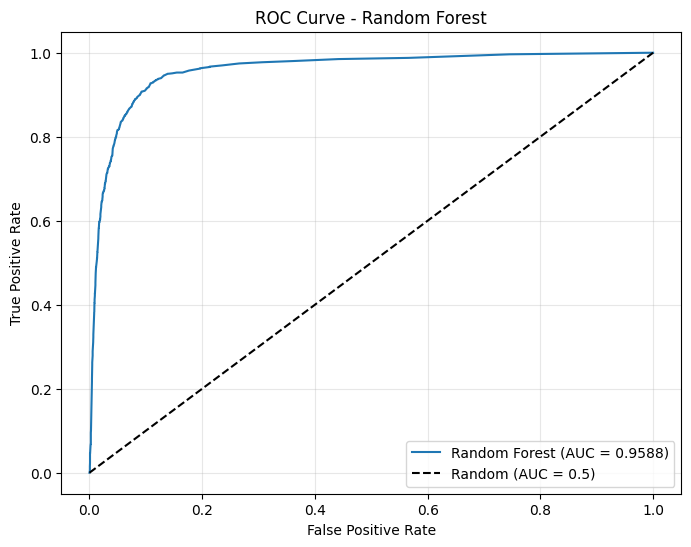

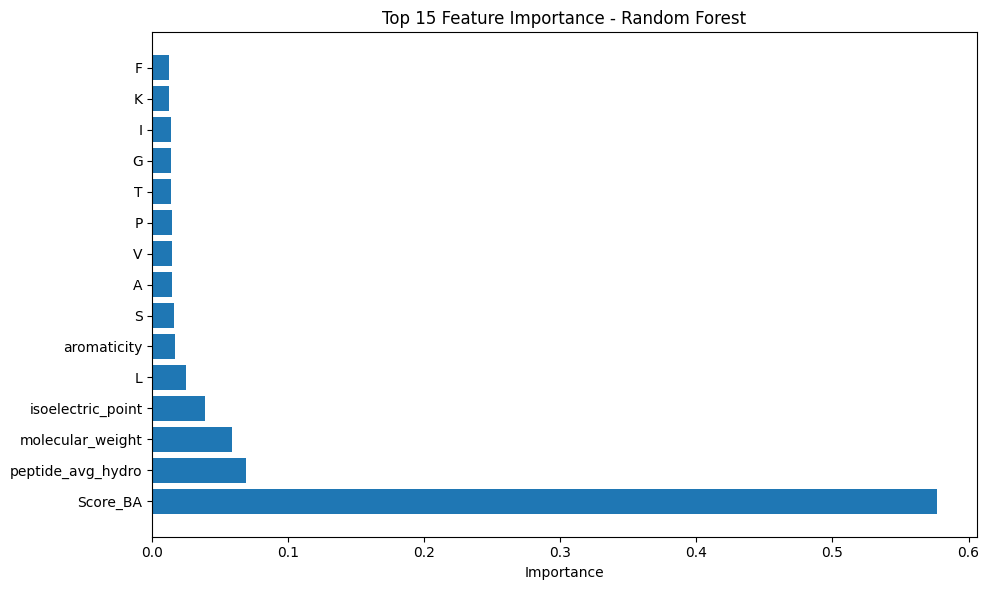

In [53]:
# Train a Random Forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=None,    # Maximum depth of trees
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability estimates for positive class

# Evaluate the model
print("Random Forest Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(15)
plt.barh(np.arange(len(top_features)), top_features['Importance'], align='center')
plt.yticks(np.arange(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance - Random Forest')
plt.tight_layout()
plt.show()
